In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras import Input, backend
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, RandomTranslation, RandomFlip, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.backend import clear_session
from keras.regularizers import l2
from keras.optimizers import Adam

2024-09-27 12:41:07.521460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 12:41:07.521525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 12:41:07.522756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 12:41:07.529508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 12:41:08.318116: W tensorflow/compiler/tf2

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
"""
## Familiarizing with our data
"""
# Display the shape of the training data
print(x_train.shape)                # Outputs the dimensions of the training dataset, showing the number of images, height, width, and channels. 

# Display the number of dimensions of the training data
print(x_train.ndim)                 # Prints the number of dimensions in the training data array.

# Display the data type of the training data
print(x_train.dtype)                # Shows the data type of the elements in the training array.

# Display the shape of the test data
print(x_test.shape)                 # Outputs the shape of the test dataset

(50000, 32, 32, 3)
4
uint8
(10000, 32, 32, 3)


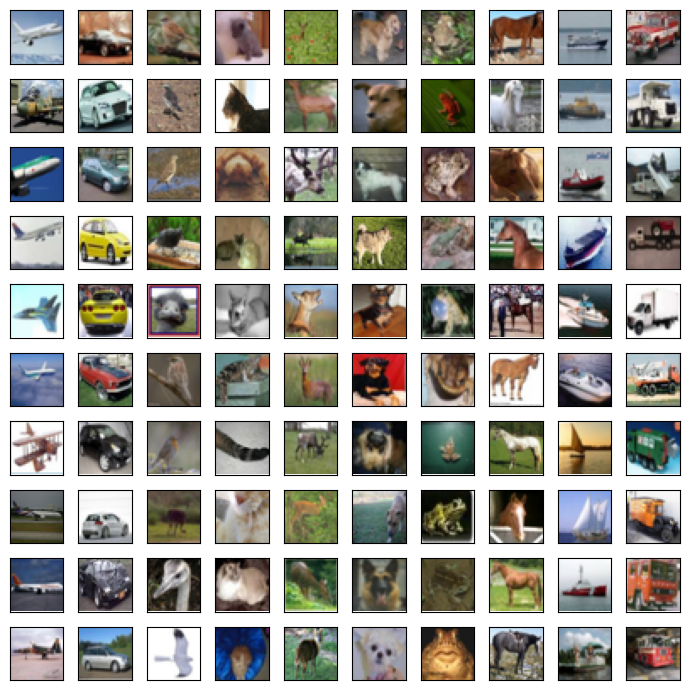

In [4]:
# Create a 10x10 grid of subplots with a specified figure size
fig, axs = plt.subplots(10, 10, figsize=(7, 7))

# Iterate over each class in the training dataset
for i, c in enumerate(np.unique(y_train)):
    # Select 10 random samples from the current class
    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)
    
    # Iterate over the 10 random samples
    for j, idx_j in enumerate(idx):
        # Get the corresponding image from the training set
        img = x_train[idx_j]
        
        # Display the image in the respective subplot
        axs[j, i].imshow(img)
        
        # Remove x and y ticks for a cleaner display
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Adjust the layout to ensure plots do not overlap
fig.tight_layout()

# Display the plot grid
plt.show()


In [5]:
"""
## Prepare the data & labels
"""

# Define the custom class names
custom_class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a Dataset object from the training data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Set the class names attribute of the Dataset object
train_dataset.class_names = custom_class_names

# Convert the labels from numerical to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Ensure the labels are correctly encoded
print(y_train.shape)
print(y_test.shape)

# Normalizing the images. Since we work with RGB channels, we divide by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Ensure the normalization worked as intended
print(x_train.shape)
print(x_test.shape)

2024-09-27 12:41:17.211913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 12:41:17.268381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 12:41:17.268581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(50000, 10)
(10000, 10)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [47]:
"""
## Building model
"""
# To make sure we start clean. 
clear_session()

# Defining the model
model = Sequential([
    Input(shape=(32, 32, 3)),     # Input layer specifying the input shape of the images (32x32 with 3 color channels)

    # Data augmentation layers
    # After experimenting with other data augmentation layers, those 2 were the ones that actually made a difference
    RandomTranslation(height_factor=0.05, width_factor=0.05),   # Randomly translates images by 5%
    RandomFlip("horizontal"),                                   # Randomly flips images horizontally

    # 1st Convolutional Block: Extracts low-level features such as edges
    Conv2D(64, (3, 3), padding='same'), BatchNormalization(), Activation("relu"), # 1st conv layer 64 filters and 3x3 kernel & Normalization & ReLU activation function for non-linearity
    Conv2D(64, (3, 3), padding='same'), BatchNormalization(), Activation("relu"), # 2nd conv layer
    MaxPooling2D((2, 2)),                                                         # Downsamples feature maps by taking max values in 2x2 blocks
    Dropout(0.1),                                                                 # Dropout layer to prevent overfitting by randomly deactivating neurons

    # 2nd Convolutional Block: Learns more complex patterns and textures. Filters increased to 128
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 3rd Convolutional Block: Further refines features and learns higher-level representations. Filters increased to 256 on first layer
    Conv2D(256, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    Conv2D(128, (3, 3), padding='same'), BatchNormalization(), Activation("relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten the feature maps into a single 1D vector to prepare for dense layers
    Flatten(),
    
    # Fully connected layer for further learning with L2 regularization to reduce overfitting
    Dense(128, kernel_regularizer=l2(0.005)), BatchNormalization(), Activation("relu"),
    Dropout(0.3),

    # Output Layer: 10 neurons for the 10 classes of CIFAR-10 dataset with softmax for class probabilities
    Dense(10, activation='softmax')
])

# Show the model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation (Random  (None, 32, 32, 3)         0         
 Translation)                                                    
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3

In [48]:
"""
## Defining our own loss function
    This function aims to emphasize the loss from classes that are proving harder to classify.
    By doing this we put more work on harder classes and less on easier to identify. 
    We reduce the overall loss and improve our overfitting. 
"""


def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for multi-class classification.
    
    Args:
        gamma (float): Focusing parameter. Higher values put more focus on hard-to-classify samples.
        alpha (float): Balancing factor to reduce the impact of easy negatives and amplify the importance of hard positives.
    
    Returns:
        Loss function to be used with model.compile.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0) error
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Compute the cross-entropy loss
        ce_loss = -y_true * tf.keras.backend.log(y_pred)
        
        # Calculate the focal loss component
        loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * ce_loss
        
        # Return the mean loss across all samples
        return tf.keras.backend.sum(loss, axis=1)
    
    return focal_loss_fixed

In [49]:
"""
## Training our model
    Compiling the model with the chosen optimizer, loss function, and metrics
    The Adam optimizer generally performs well with deep learning models due to its adaptive learning rate properties.
    Focal loss is used here instead of categorical cross-entropy because it penalizes hard-to-classify samples more,
    helping the model focus on classes that are more difficult to learn, particularly useful for imbalanced data.
"""

# Compiling the model
model.compile(
    optimizer=Adam(), #Adam showed significantly better results than SDG
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
    )
# Calculating class weights to balance the training data.
# This adjustment helps the model learn better by giving more importance to underrepresented classes.
class_weights = compute_class_weight(class_weight='balanced',                   # The 'balanced' mode computes the weights inversely proportional to class frequencies.
                                     classes=np.unique(y_train.argmax(axis=1)),
                                     y=y_train.argmax(axis=1))

# Convert the class weights into a dictionary format
class_weights_dict = dict(enumerate(class_weights))

# Manually increasing the weights for classes 3 and 5 as they are identified as most problematic.
# This adjustment is a targeted intervention to help the model focus more on these classes.
class_weights_dict[3] *= 2      # Doubling the weight of class 3 to help the model pay more attention
class_weights_dict[5] *= 2      # Doubling the weight of class 5 as it struggles with recognition

# Defining early stopping criteria to avoid overfitting.
# This stops training when validation accuracy stops improving for a certain number of epochs, restoring the best weights.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True) #Monitoring validation accuracy, after 5 epochs of no improvement it stops.

# Learning Rate Scheduler to adjust the learning rate during training.
# Reduces the learning rate when the validation accuracy plateaus, which helps refine the learning process.
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)  # Reduces learning rate by half if no improvement

# Training the model
# Using a batch size of 128 for balanced computation efficiency and gradient updates.
# Training for up to 100 epochs or until early stopping is triggered.
# Validation split of 0.2 means 20% of the training data is used for validation.
# Class weights are applied to handle class imbalance and focus on problematic classes.
history = model.fit(
    x_train, y_train,
    epochs=100,                                 # Maximum number of training epochs
    batch_size=128,                             # Size of each mini-batch
    validation_split=0.2,                       # 20% of the training data is used for validation
    class_weight=class_weights_dict,            # Applying the calculated class weights
    callbacks=[early_stopping, lr_scheduler]    # Early stopping and learning rate scheduler
)

Epoch 1/100


2024-09-27 13:23:52.132782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 10s 22ms/step - loss: 0.6438 - accuracy: 0.4170 - val_loss: 0.6501 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.2865 - accuracy: 0.5736 - val_loss: 0.2463 - val_accuracy: 0.5816 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.2428 - accuracy: 0.6425 - val_loss: 0.2185 - val_accuracy: 0.6324 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.2222 - accuracy: 0.6798 - val_loss: 0.2031 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.2080 - accuracy: 0.7081 - val_loss: 0.1903 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.1948 - accuracy: 0.7255 - val_loss: 0.1919 - val_accuracy: 0.6998 - lr: 0.0010
Epoch 7/100
313/313 [==============================] - 7s 22ms/step -

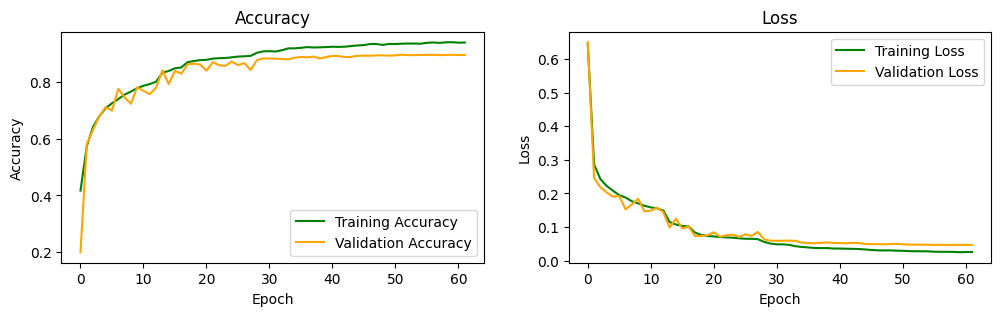

313/313 [==============================] - 1s 3ms/step - loss: 0.0475 - accuracy: 0.8947
Training Accuracy:	0.9395,	Loss: 0.0255
Validation Accuracy:	0.8958,	Loss: 0.0466
Test Accuracy:		0.8947,	Loss: 0.0475


In [50]:
"""
## Model evaluation
    1- Observe the accuracy and loss curves and compare between training and validation data.
    2- Obtain the accuracy and loss values for training, validation and test datasets
"""


# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(12, 3))                                                             # Set figure size for better visualization
plt.subplot(1, 2, 1)                                                                    # Create subplot for accuracy
plt.title('Accuracy')                                                                   # Title for the accuracy plot
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')         # Plot training accuracy
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')  # Plot validation accuracy
plt.xlabel('Epoch')                                                                     # X-axis label
plt.ylabel('Accuracy')                                                                  # Y-axis label
plt.legend()                                                                            # Show legend to differentiate between training and validation

# Plotting the training and validation loss over epochs
plt.subplot(1, 2, 2)                                                                    # Create subplot for loss
plt.title('Loss')                                                                       # Title for the loss plot
plt.plot(history.history['loss'], color='green', label='Training Loss')                 # Plot training loss
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')          # Plot validation loss
plt.xlabel('Epoch')                                                                     # X-axis label
plt.ylabel('Loss')                                                                      # Y-axis label
plt.legend()                                                                            # Show legend to differentiate between training and validation
plt.show()                                                                              # Display the plots

# Evaluate the model's performance on the test set
# This provides the final accuracy and loss on unseen data, which helps to gauge the model's generalization ability.
test_loss, test_acc = model.evaluate(x_test, y_test)

# Extract the final training accuracy and loss from the history object
# These values represent the model's performance on the training data at the last epoch.
train_acc = history.history['accuracy'][-1]                                             # Training accuracy from the last epoch
train_loss = history.history['loss'][-1]                                                # Training loss from the last epoch

# Extract the final validation accuracy and loss from the history object
# Validation metrics help assess how well the model performs on data it hasn't been trained on, helping to identify overfitting.
val_acc = history.history['val_accuracy'][-1]   # Validation accuracy from the last epoch
val_loss = history.history['val_loss'][-1]      # Validation loss from the last epoch

# Print the training, validation, and test results
# This provides a clear summary of the model's performance across different data splits.
print(f'Training Accuracy:\t{train_acc:.4f},\tLoss: {train_loss:.4f}')                    # Print training metrics
print(f'Validation Accuracy:\t{val_acc:.4f},\tLoss: {val_loss:.4f}')    # Print validation metrics
print(f'Test Accuracy:\t\t{test_acc:.4f},\tLoss: {test_loss:.4f}')      # Print test metrics


313/313 [==============================] - 1s 2ms/step


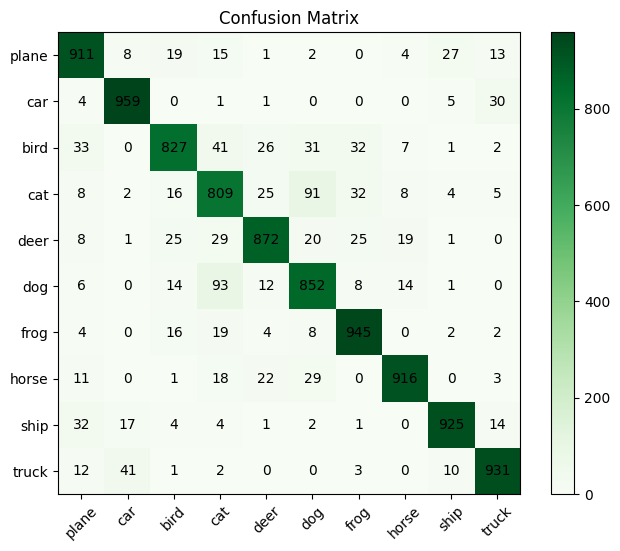

              precision    recall  f1-score   support

       plane       0.89      0.91      0.90      1000
         car       0.93      0.96      0.95      1000
        bird       0.90      0.83      0.86      1000
         cat       0.78      0.81      0.80      1000
        deer       0.90      0.87      0.89      1000
         dog       0.82      0.85      0.84      1000
        frog       0.90      0.94      0.92      1000
       horse       0.95      0.92      0.93      1000
        ship       0.95      0.93      0.94      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [51]:
"""
## Model evaluation
    1-Plotting and evaluation of the confusion matrix
    2- Analyze precision, recall, f1-score and support for each class and on overall average. 
"""


# Making predictions on the test set
y_pred = model.predict(x_test)

# Creating a confusion matrix
cm = confusion_matrix(
    np.argmax(y_test, axis=1),                                                 # True class labels converted from one-hot encoding to class indices
    np.argmax(y_pred, axis=1)                                                  # Predicted class labels converted from one-hot encoding to class indices
)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))                                                     #   Set figure size to make the plot readable
plt.imshow(cm, interpolation='nearest', cmap='Greens')                         # Display the confusion matrix with a green color map
plt.title('Confusion Matrix')                                                  # Set the title of the plot
plt.colorbar()                                                                 # Add a color bar to interpret the matrix values visually

# Use the custom class names as tick labels
plt.xticks(range(len(custom_class_names)), custom_class_names, rotation=45)    # Set x-axis tick marks and labels with a 45-degree rotation
plt.yticks(range(len(custom_class_names)), custom_class_names)                 # Set y-axis tick marks and labels

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):                                                   # Iterate over rows
    for j in range(cm.shape[1]):                                               # Iterate over columns
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')      # Add the count in each cell with black text

plt.show()  # Display the confusion matrix plot

# Ensure both y_test and y_pred_class are in the same format
y_test_class = np.argmax(y_test, axis=1)

# Display a classification report
# This report provides precision, recall, f1-score, and support for each class, giving a comprehensive evaluation of model performance.
print(classification_report(y_test_class, np.argmax(y_pred, axis=1), target_names=custom_class_names))


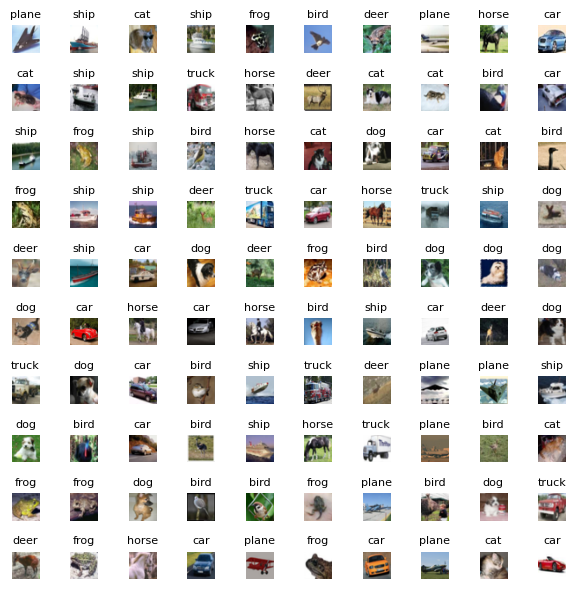

In [52]:
"""
## Model evaluation
    1-Visualisation of images from our test dataset and its predictions.
"""

# Select a number of random examples from the test dataset
num_examples = 100                                                          # Number of examples to display
indices = np.random.choice(x_test.shape[0], num_examples, replace=False)    # Randomly select indices without replacement
x_examples = x_test[indices]                                                # Extract the corresponding images
y_examples = y_test[indices]                                                # Extract the corresponding labels

# Create a figure with subplots
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))                # Create a 10x10 grid of subplots with a figure size of 6x6 inches

# Loop through the selected examples and display the images with their class labels
for i, (x, y) in enumerate(zip(x_examples, y_examples)):
    ax = axes[i // 10, i % 10]                                              # Determine the subplot location in the 10x10 grid
    ax.imshow(x)                                                            # Display the image in the subplot
    ax.set_title(custom_class_names[np.argmax(y)], fontsize=8)              # Set the title of the subplot to the class name with a font size of 8
    ax.axis('off')                                                          # Turn off the axis for a cleaner look

# Adjust the layout of the plots to prevent overlap
plt.tight_layout()                                                          # Automatically adjust subplot parameters for better layout
plt.show()                                                                  # Display the plot


In [53]:
"""
## Model evaluation
    1-Visualisation of an image of our choice using the widget. We can specifically look at images and their prediction.
"""

import ipywidgets as widgets
from IPython.display import display

# Create an image selection widget using a slider
image_selector = widgets.IntSlider(
    value=0,                                                    # Initial value set to 0
    min=0,                                                      # Minimum value of the slider
    max=len(x_test) - 1,                                        # Maximum value based on the length of the test dataset
    step=1,                                                     # Step size of 1 to move between indices
    description='Image Index:',                                 # Description label for the slider
    style={'description_width': 'initial'}                      # Style to set the width of the description label
)

# Create a button widget to trigger the prediction
predict_button = widgets.Button(description="Predict Class")

# Create an output area widget to display results
output = widgets.Output()

# Display the widgets in the notebook
display(image_selector, predict_button, output)

# Define a function to handle the prediction and display the image and results
def predict_image(change):
    with output:                                                # Use the output widget to display results
        output.clear_output()                                   # Clear any previous output

        # Get the selected image index from the slider
        index = image_selector.value

        # Display the selected image
        plt.imshow(x_test[index])                               # Show the image from the test set at the selected index
        plt.title("Selected Image")                             # Title of the plot
        plt.axis('off')                                         # Turn off axis lines and labels
        plt.show()                                              # Display the image

        # Get the true label of the selected image
        true_label = custom_class_names[np.argmax(y_test[index])]  # Convert one-hot encoded label to class name

        # Prepare the image for prediction by adding a batch dimension
        image = np.expand_dims(x_test[index], axis=0)           # Reshape image for model input

        # Get predicted probabilities from the model
        predicted_probabilities = model.predict(image)          # Predict class probabilities

        # Determine the predicted class from the probabilities
        predicted_class = custom_class_names[np.argmax(predicted_probabilities)]  # Convert predicted probabilities to class name

        # Display the true label and predicted class
        print(f"True Label: {true_label}")                      # Show the actual class name
        print(f"Predicted Class: {predicted_class}")            # Show the predicted class name

# Connect the button to the prediction function so it runs when the button is clicked
predict_button.on_click(predict_image)


IntSlider(value=0, description='Image Index:', max=9999, style=SliderStyle(description_width='initial'))

Button(description='Predict Class', style=ButtonStyle())

Output()

In [54]:
"""
## Model saving
    1- Used to create the diagram of our model
"""
#model.save('G3_model.keras')


'\n## Model saving\n    1- Used to create the diagram of our model\n'